*Estimated QPU usage: 4 minutes (tested on IBM Kyiv)*

## Background

In this tutorial, you will run an experiment on a quantum computer to demonstrate the violation of the CHSH inequality with the Estimator primitive.

The CHSH inequality, named after the authors Clauser, Horne, Shimony, and Holt, is used to experimentally prove Bell's theorem (1969). This theorem asserts that local hidden variable theories cannot account for some consequences of entanglement in quantum mechanics. The violation of the CHSH inequality is used to show that quantum mechanics is incompatible with local hidden-variable theories. This is an important experiment for understanding the foundation of quantum mechanics.

The 2022 Nobel Prize for Physics was awarded to Alain Aspect, John Clauser and Anton Zeilinger in part for their pioneering work in quantum information science, and in particular, for their experiments with entangled photons demonstrating violation of Bell’s inequalities.


## Step 1. Map classical inputs to a quantum problem


For this experiment, we will create an entangled pair on which we measure each qubit on two different bases. We will label the bases for the first qubit $A$ and $a$ and the bases for the second qubit $B$ and $b$.  This allows us to compute the CHSH quantity $S_1$:

$$
S_1 = A(B-b) + a(B+b).
$$

Each observable is either $+1$ or $-1$. Clearly, one of the terms $B\pm b$ must be $0$, and the other must be $\pm 2$.  Therefore, $S_1 = \pm 2$. The average value of $S_1$ must satisfy the inequality:

$$
|\langle S_1 \rangle|\leq 2.
$$

Expanding $S_1$ in terms of $A$, $a$, $B$, and $b$ results in:

$$
|\langle S_1 \rangle| = |\langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle| \leq 2
$$

You can define another CHSH quantity $S_2$:

$$
S_2 = A(B+b) - a(B-b),
$$

This leads to another inequality:

$$
|\langle S_2 \rangle| = |\langle AB \rangle + \langle Ab \rangle - \langle aB \rangle + \langle ab \rangle| \leq 2
$$

If quantum mechanics can be described by local hidden variable theories, the previous inequalities must hold true. However, as is demonstrated in this notebook, these inequalities can be violated in a quantum computer.  Therefore, quantum mechanics is not compatible with local hidden variable theories.


You will create an entangled pair between two qubits in a quantum computer by creating the Bell state $|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$. Using the Estimator primitive, you can directly obtain the expectation values needed ($\langle AB \rangle, \langle Ab \rangle, \langle aB \rangle$, and $\langle ab \rangle$) to calculate the expectation values of the two CHSH quantities $\langle S_1\rangle$ and $\langle S_2\rangle$. Before the introduction of the Estimator primitive, you would have to construct the expectation values from the measurement outcomes.

You will measure the second qubit in the $Z$ and $X$ bases.  The first qubit will be measured also in orthogonal bases, but with an angle with respect to the second qubit, which we are going to sweep between $0$ and $2\pi$. As you will see, the Estimator primitive makes running parameterized circuits very easy. Rather than creating a series of CHSH circuits, you only need to create *one* CHSH circuit with a parameter specifying the measurement angle and a series of phase values for the parameter.

Finally, you will analyze the results and plot them against the measurement angle. You will see that for certain range of measurement angles, the expectation values of CHSH quantities $|\langle S_1\rangle| > 2$ or $|\langle S_2\rangle| > 2$, which demonstrates the violation of the CHSH inequality.


In [89]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Options, Session, SamplerV2 as Sampler
backend_sim = AerSimulator()
simulator = AerSimulator()

#Import an estimator, this time from qiskit (we import from Runtime for real hardware)
from qiskit.primitives import BackendSampler
sampler = BackendSampler(backend = backend_sim)
import numpy as np
from qiskit.visualization import plot_bloch_vector, plot_histogram
import matplotlib.pyplot as plt

from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit, Parameter
from qiskit import QuantumCircuit, transpile
from qiskit.result import marginal_counts
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator


import matplotlib.ticker as tck



/var/folders/r8/01h7mk295_qg6429pfv0cscc0000gn/T/ipykernel_14303/3344170123.py:8: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler = BackendSampler(backend = backend_sim)


In [90]:
backend = AerSimulator()

### On qubit 1 we are going to measure in the A = X basis and on the orthogonal a = Z basis
### On qubit 2 we are going to measure in two orthogonal basis B,b which are rotated by an angle $\theta$ from the first one

In [91]:
number_of_phases = 21
phases = np.linspace(0, 2 * np.pi, number_of_phases)
# Phases need to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]

# <CHSH1> = <AB> - <Ab> + <aB> + <ab> -> <ZZ> - <ZX> + <XZ> + <XX>

# <CHSH2> = <AB> + <Ab> - <aB> + <ab> -> <ZZ> + <ZX> - <XZ> + <XX>

### We can test two different order in the inequality
$$
<CHSH1> = <AB> - <Ab> + <aB> + <ab> -> <ZZ> - <ZX> + <XZ> + <XX>
$$
$$
<CHSH2> = <AB> + <Ab> - <aB> + <ab> -> <ZZ> + <ZX> - <XZ> + <XX>
$$

We need therefore to prepare 4 different circuits (4 different measurements), and save the average values

In [92]:
# Here you are the basic circuit to prepare the Bell state and rotate the first qubit axis measurement by theta
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

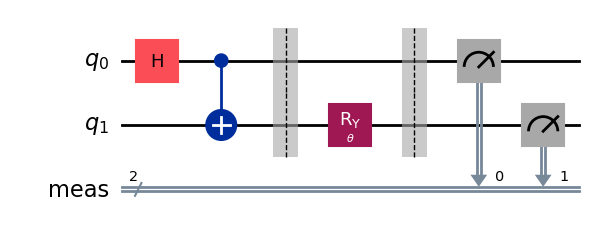

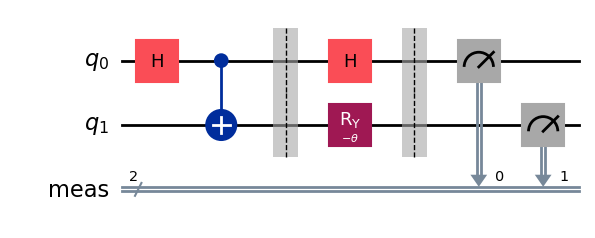

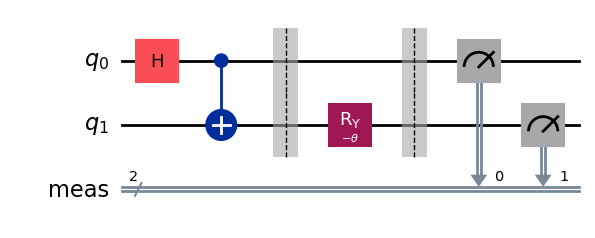

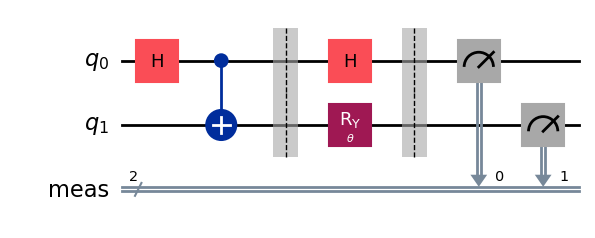

In [129]:
# Exercise: Build the 4 circuits and measure the expectation value of the CHSH operator (you can use the parametrized circuit)
theta = Parameter("$\\theta$")

qc1 = QuantumCircuit(2)
qc1.h(0)
qc1.cx(0,1)
qc1.barrier()
qc1.ry(theta, 1)
qc1.measure_all()
display(qc1.draw('mpl'))

qc2 = QuantumCircuit(2)
qc2.h(0)
qc2.cx(0,1)
qc2.barrier()
qc2.h(0)
qc2.ry(-theta, 1)
qc2.measure_all()
display(qc2.draw('mpl'))

qc3 = QuantumCircuit(2)
qc3.h(0)
qc3.cx(0,1)
qc3.barrier()
qc3.ry(-theta, 1)
qc3.measure_all()
display(qc3.draw('mpl'))

qc4 = QuantumCircuit(2)
qc4.h(0)
qc4.cx(0,1)
qc4.barrier()
qc4.h(0)
qc4.ry(theta, 1)
qc4.measure_all()
display(qc4.draw('mpl'))

chsh_circuits = [qc1, qc2, qc3, qc4]

In [95]:
shots = 1024
results_pi_4 = []
for i in range(4):
    bound_circuit = chsh_circuits[i].assign_parameters({theta: np.pi/4})
    counts = backend.run(bound_circuit, shots=shots).result().get_counts()

    mean = 0
    for key in counts.keys():
        mean += mapping[int(key[0])]*mapping[int(key[1])]*counts[key]/shots
    results_pi_4.append(mean)
    
print('<CHSH1> = ' + str(results[e, 0] + results[e, 1] + results[e, 2] - results[e, 3]))
print('<CHSH2> = ' + str(results[e, 0] - results[e, 1] + results[e, 2] + results[e, 3]))

<CHSH1> = 2.8515625
<CHSH2> = 0.0546875


In [100]:
# Exercise: Build the 4 circuits and measure the expectation value of the CHSH operator (you can use the parametrized circuit)
number_of_phases = 100
phases = np.linspace(0, 2 * np.pi, number_of_phases)

results = np.zeros((number_of_phases,4))

chsh1_est = []
chsh2_est = []
for e in range(number_of_phases):
    for i in range(4):
        bound_circuit = chsh_circuits[i].assign_parameters({theta: phases[e]})
        counts = backend.run(bound_circuit, shots=shots).result().get_counts()
        for key in counts.keys():
            results[e,i] += mapping[int(key[0])]*mapping[int(key[1])]*counts[key]/shots

    chsh1_est.append(results[e, 0] + results[e, 1] + results[e, 2] - results[e, 3])
    chsh2_est.append(results[e, 0] - results[e, 1] + results[e, 2] + results[e, 3])

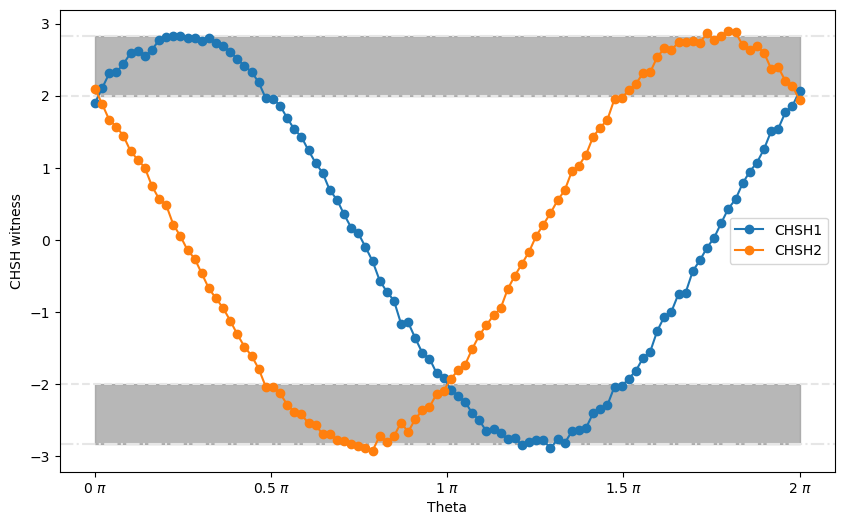

In [101]:
fig, ax = plt.subplots(figsize=(10, 6))

# save in chsh1_est the expectation value just computed for <ZZ> per each phase
# save in chsh2_est the expectation value just computed for <XX> per each phase

# results from hardware
ax.plot(phases / np.pi, chsh1_est, "o-", label="CHSH1", zorder=3)
ax.plot(phases / np.pi, chsh2_est, "o-", label="CHSH2", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))

# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()

### Using the codes of yesterday, proceed now to run it on a QPU

In [102]:
# transpiling the circuits
from qiskit_ibm_runtime import QiskitRuntimeService
# Let s find the least busy backend
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy()
print(backend.name)
sampler = Sampler(mode=backend)
sampler.options.default_shots = 100

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level=3, backend=backend) 

ibm_kyiv


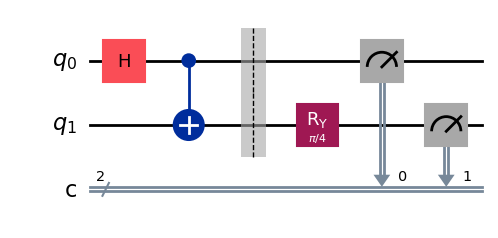

In [103]:
qc = QuantumCircuit(2,2)

qc.h(0)
qc.cx(0,1)

qc.barrier()
qc.ry(np.pi/4,1)
qc.measure(0,0)
qc.measure(1,1)

qc.draw('mpl')

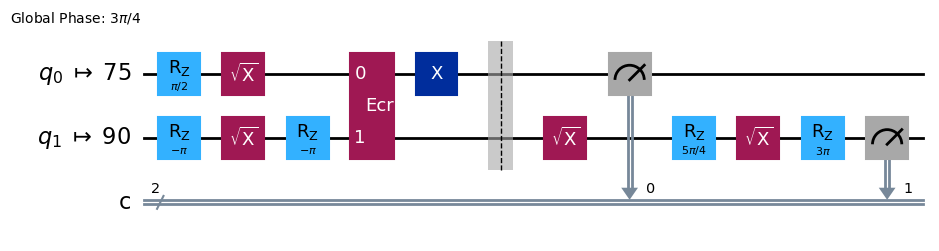

In [104]:
qc_qpu = pm.run(qc)
qc_qpu.draw('mpl', idle_wires = False)

In [105]:
job = sampler.run([(qc_qpu, [], 1_000)])

In [108]:
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cza3e81b7tt0008g4h3g
>>> Job Status: DONE


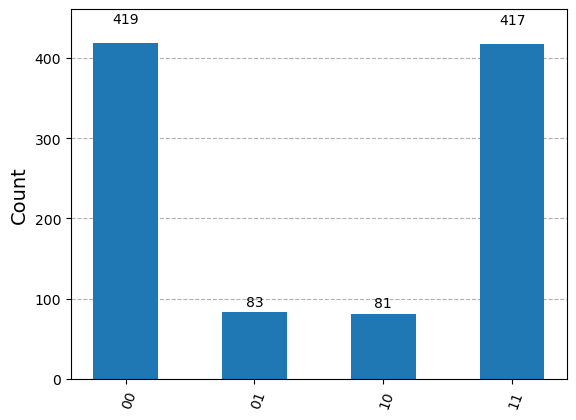

In [109]:
result = job.result()
counts = result[0].data.c.get_counts()
plot_histogram(counts)

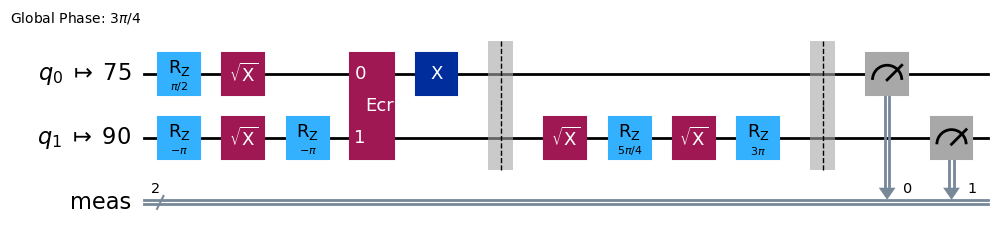

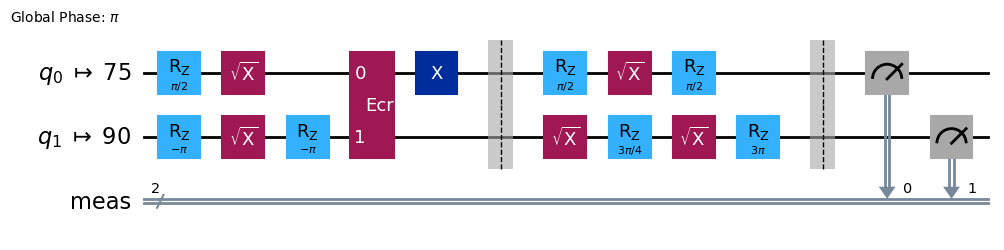

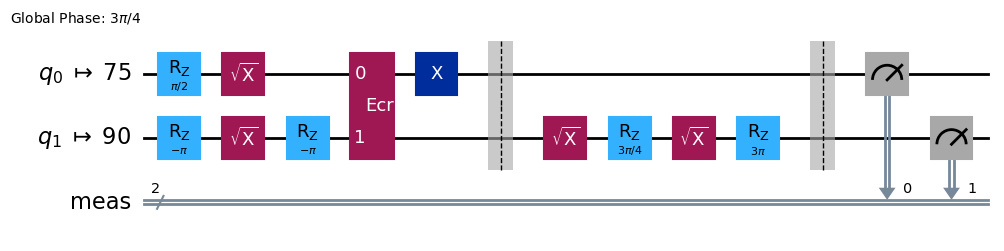

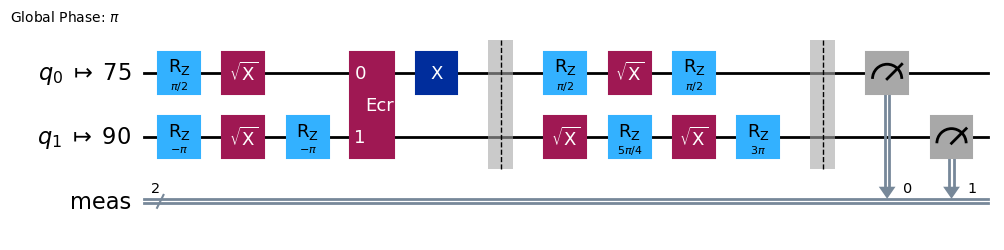

In [112]:
chsh_circuits_qpu = []
for i in range(4):
    bound_circuit = chsh_circuits[i].assign_parameters({theta: np.pi/4})
    chsh_circuits_qpu.append(pm.run(bound_circuit))
    display(chsh_circuits_qpu[i].draw('mpl', idle_wires = False))

In [113]:
run_qpu = [(chsh_circuits_qpu[i], [], 1_000) for i in range(4)]
job = sampler.run(run_qpu)

In [119]:
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cza3gwbr3jrg008nwgwg
>>> Job Status: DONE


In [120]:
result = job.result()
result[0].data.meas

BitArray(<shape=(), num_shots=1000, num_bits=2>)

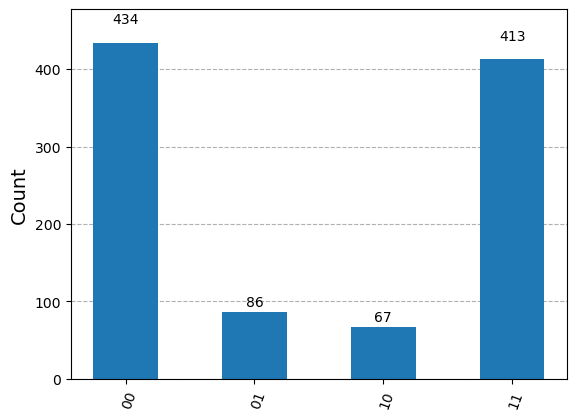

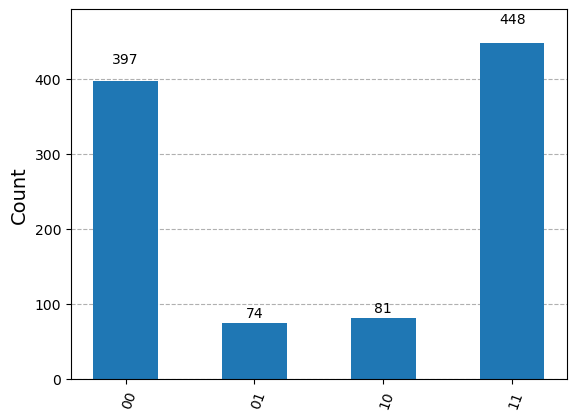

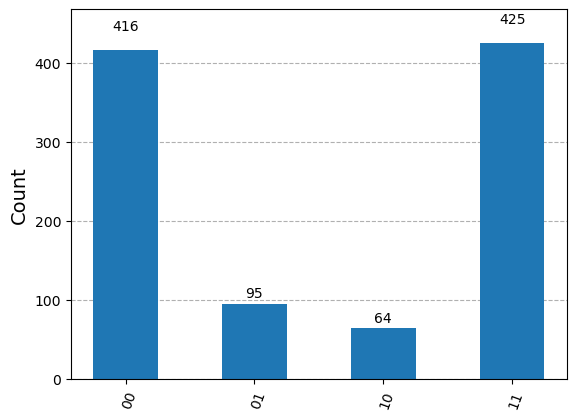

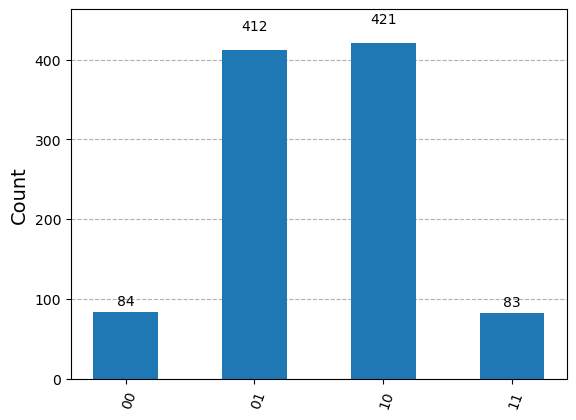

In [121]:
result = job.result()
counts = []
for i in range(4):
    counts.append(result[i].data.meas.get_counts())
    display(plot_histogram(counts[i]))

In [122]:
shots = 1_000

means = []

for i in range(4):
    mean = 0
    mapping = {1: 1, 0: -1}
    for key in counts_1.keys():
        mean += mapping[int(key[0])]*mapping[int(key[1])]*counts[i][key]/shots
    means.append(mean)

print('<CHSH1> = ' + str(means[0] + means[1] + means[2] - means[3]))
print('<CHSH2> = ' + str(means[0] - means[1] + means[2] + means[3]))

<CHSH1> = 2.7319999999999998
<CHSH2> = 0.019999999999999907


In [124]:
errors = [np.sqrt(1-means[i]**2)/np.sqrt(shots) for i in range(4)]
print(sum(errors))

0.09237292211696554


In [131]:
number_of_phases = 10
phases = np.linspace(0, 2 * np.pi, number_of_phases)

results = np.zeros((number_of_phases,4))

chsh1_est = []
chsh2_est = []
for e in range(number_of_phases):
    chsh_circuits_qpu = []
    for i in range(4):
        bound_circuit = chsh_circuits[i].assign_parameters({theta: phases[e]})
        chsh_circuits_qpu.append(pm.run(bound_circuit)) 
    job = sampler.run([(chsh_circuits_qpu[i], [], 1_000) for i in range(4)])
    result = job.result()

    for i in range(4):
        count = result[i].data.meas.get_counts()
        mapping = {1: 1, 0: -1}
        for key in count.keys():
            results[e,i] += mapping[int(key[0])]*mapping[int(key[1])]*count[key]/shots
            
    chsh1_est.append(results[e, 0] + results[e, 1] + results[e, 2] - results[e, 3])
    chsh2_est.append(results[e, 0] - results[e, 1] + results[e, 2] + results[e, 3])

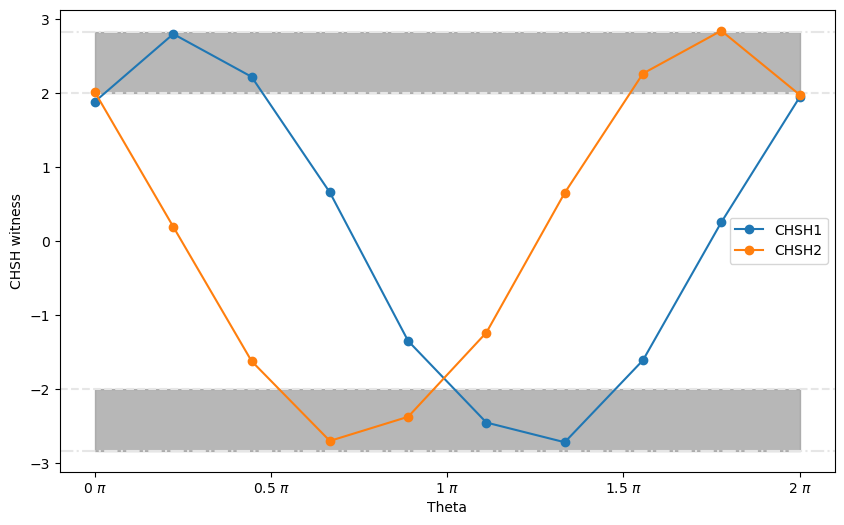

In [132]:
fig, ax = plt.subplots(figsize=(10, 6))

# save in chsh1_est the expectation value just computed for <ZZ> per each phase
# save in chsh2_est the expectation value just computed for <XX> per each phase

# results from hardware
ax.plot(phases / np.pi, chsh1_est, "o-", label="CHSH1", zorder=3)
ax.plot(phases / np.pi, chsh2_est, "o-", label="CHSH2", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))

# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()